In [ ]:
:orphan:

In [100]:
import numpy as tnp
import matplotlib.pyplot as plt
import dLux as dl
import dLux.layers as dll
import jax.random as jr
from jax import jacrev, hessian, random
from jax.scipy.stats import norm

# The Katsu Stuff
from katsu.katsu_math import set_backend_to_jax
set_backend_to_jax()
from katsu.katsu_math import (
    np,
    broadcast_kron,
    condition_number
)
from katsu.mueller import(
    linear_diattenuator,
    linear_retarder
)

det_npix = 32

# Dual Rotating Retarder Polarimetry with Fisher Information

## 1. Review of Bayesian Experimental Design

Consider a polarimeter parameterized by a vector $\mathbf{\theta}$ of independent parameters that generates some data $d$. To solve the inverse problem, you want to infer $\mathbf{\theta}$ from $d$ (and any prior information). Using Bayes' rule, we can _update_ our prior knowledge of our parameters $\mathbf{\theta}$ conditioned on our prior knowledge $I$ given the data $d$.

$$ p(\mathbf{\theta} | d, I) = \frac{p(d|\mathbf{\theta},I) \cdot p(\mathbf{\theta | I})}{p(d | I)} $$

In other words, our posterior (updated) probability is equal to the likelihood of our data given our parameters, multiplied by the probability of our parameters given our prior knowledge, divided by the probability of our data given our prior information. 

Bayes' rule can be equivalently expressed in logarithmic units, as shwon below

$$logp(\mathbf{\theta} | d, I) = \mathcal{L}(d|\mathbf{\theta},I) + \Pi (\mathbf{\theta | I}) - log Z $$

If the log-likelihood is approximated as a multivariate normal (Laplace's method), then we can derive a relation that proves the Hessian of $\mathcal{L}$ to be the Fisher Information Matrix $\mathbf{F}$. The parameter covariance is then the negative inverse of the Fisher Information.

$$\mathbf{C} = -\mathbf{F}^{-1}$$

Which describes the best-fit multivariate normal to the behavior of a likelihood distribution near the peak. The Fisher Information Matrix has a couple of convenient properties:
- Fisher matrices for two independent experiments add
- Parameter marginalization happens through matrix inversion of $\mathbf{F}$, row and column $i$ can be revomed to remove their contribution to the covariance matrix.
- The covariance matrix of a model $f$ with parameters $\mathbf{\theta}$ calculated using the observation produced by that model given the parameters is the Cramer-Row-Lower Bound, which describes the information theoretical limit of performance of any given model.

## 2. Determination of a Likelihood Function

In photon-saturated cases it is sufficient to state that we are photon noise limited. However, for the Dual-rotating retarder polarimeter we may experience a condition where the polarization state of the generator and analyzer are nearly orthogonal, where we will then be limited by the noise of the detector. Our noise funciton $\mathcal{N}$ will then be a function of both the number of incident photons and the detector dark current.

We assume an ability to 
Below we add the `add_camera_noise` function which simulates these noise sources, which will let us expose our result

In [130]:
def add_camera_noise(Nphotons, qe=0.69, dark_current=2.29, bitdepth=12, seed=random.key(42)):
    """Simulate a camera exposure

    function from http://kmdouglass.github.io/posts/modeling-noise-for-image-simulations/
    with modifications to support Jax behavior

    Parameters
    ----------
    Nphotons : int
        number of photons incident on a camera pixel
    qe : float, optional
        electrons per photon, by default 0.69
    dark_current : float, optional
        standard deviation of electrons, by default 2.29
    bitdepth : int, optional
        number of bits detector can resolve, by default 12
    seed : np.random.RandomState, optional
        random seed for simulation, by default np.random.RandomState(seed=42)
    """
    # photon noise
    photons = random.poisson(seed, Nphotons)

    # convert to electrons
    electrons = qe * photons

    # dark current
    electrons_out = random.normal(seed)/1e3 + electrons

    # ADU
    max_adu = int(2**bitdepth - 1)
    adu = (electrons_out).astype(int)
    adu = adu.at[adu > max_adu].set(max_adu)

    return adu

Here $I$ is Stokes intensity parameter, not prior

$P(I) \rightarrow$ PDF of photons emitted

$P(I'|\mathbf{\theta}) \rightarrow$ PDF of detected photo-electrons

$P(I'|\mathbf{\theta}) = \mathbf{M}(\mathbf{\theta}) p(I)$

$N(T) \rightarrow$ PDF of detector noise

$p(e^{-}|\mathbf{\theta}) = P(I') + N(T) \rightarrow$ PDF of detecting an electron given the parameter vector $\mathbf{\theta}$, i.e. the likelihood

$log(p(e^{-}|\mathbf{\theta})) = log(P(I') + N(T)) \rightarrow$ Log-likelihood


## 3. Forward Model of a DRRP Measurement
Next we need our forward model which takes our input parameters and returns some model prediction, i.e.
$$f(\mathbf{\theta}) \rightarrow P_{predict}$$

In the example below, the parameters ($\mathbf{\theta}$) of our model are:
- Number of measurements
- Angular rotation increment of PSG Retarder
- Retardance of PSG Retarder
- Angular rotation increment of PSA Retarder
- Retardance of PSA Retarder
- Fixed angle of PSG polarizer
- Fixed angle of PSA polarizer

In [131]:
def fwd_drrp(x):
    """Forward model that returns condition number of data reduction matrix

    Parameters
    ----------
    x : list or 1D array
        coefficient vector
    """

    # Load elements from coefficient vector
    Nmeas = int(x[0])
    th_g = x[1]
    ret_g = x[2]
    th_a = x[3]
    ret_a = x[4]
    th_pol_g = x[5]
    th_pol_a = x[6]

    psg_angular_steps = np.linspace(0, Nmeas * th_g, Nmeas)
    psa_angular_steps = np.linspace(0, Nmeas * th_a, Nmeas)

    # set up DRRP, assume ideal polarizer
    psg_pol = linear_diattenuator(th_pol_g, 0, shape=[det_npix, det_npix, Nmeas])
    psg_wvp = linear_retarder(psg_angular_steps, ret_g, shape=[det_npix, det_npix, Nmeas])

    psa_wvp = linear_retarder(psa_angular_steps, ret_a, shape=[det_npix, det_npix, Nmeas])
    psa_pol = linear_diattenuator(th_pol_a, 0, shape=[det_npix, det_npix, Nmeas])

    Mg = psg_wvp @ psg_pol
    Ma = psa_pol @ psa_wvp

    PSA = Ma[..., 0, :]
    PSG = Mg[..., :, 0]

    # polarimetric data reduction matrix, flatten Mueller matrix dimension
    Wmat = broadcast_kron(PSA[..., np.newaxis], PSG[..., np.newaxis])
    Wmat = Wmat.reshape([*Wmat.shape[:-2], 16])
    Winv = np.linalg.pinv(Wmat)
    Mtot = Ma @ Mg

    return Mtot[..., 0, 0] * 1

In [132]:
Nmeas = 40.
th_g = np.radians(10.)
ret_g = 2 * np.pi / 3
th_a = np.radians(25.)
ret_a = 2 * np.pi / 3
th_pol_g = 0.
th_pol_a = np.pi / 2

x0 = [Nmeas, th_g, ret_g, th_a, ret_a, th_pol_g, th_pol_a] 
power = fwd_drrp(x0)
power = np.moveaxis(power, -1, 0)

In [141]:
N_EXPOSURES = 5
power_scale = 10
data = []
error = []

for p in power:

    noisy_frames = []

    # expose the frame N = 5 times
    for i in range(N_EXPOSURES):
        noisy_frames.append(add_camera_noise(p * power_scale))

    data.append(np.mean(np.asarray(noisy_frames), axis=0))
    error.append(np.std(np.asarray(noisy_frames), axis=0))

# Using dLux for Noise Simulation

Just a simple noisy detector, looks like we get to suppy our own pixel response so that's cool

In [149]:
det_npix = 32
pix_response = 1 + 0.05*jr.normal(jr.PRNGKey(0), [det_npix, det_npix]) + jr.poisson(jr.PRNGKey(0), lam=1)
detector = dl.LayeredDetector([dll.ApplyPixelResponse(pix_response)])

In [150]:
x = np.linspace(-1, 1, det_npix)
x, y = np.meshgrid(x, x)
mask = np.zeros_like(x)
mask = mask.at[np.sqrt(x**2 + y**2) < 1].set(1.)

In [156]:
# update the pix response
pix_response = 1 + 0.05*jr.normal(jr.PRNGKey(0), [det_npix, det_npix])
detector = dl.LayeredDetector([dll.ApplyPixelResponse(pix_response)])

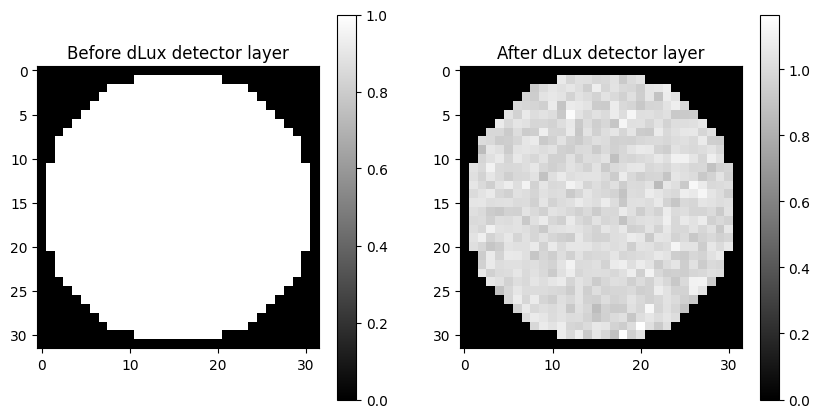

In [157]:
cm = 'gray'
plt.figure(figsize=[10, 5])
plt.subplot(121)
plt.title('Before dLux detector layer')
plt.imshow(mask, cmap=cm)
plt.colorbar()
plt.subplot(122)
plt.title('After dLux detector layer')
plt.imshow(detector.model(mask, return_psf=True), cmap=cm)
plt.colorbar()
plt.show()

# Spatially-resolved polarimetry (with noise)

In [158]:
Nmeas = 40.
th_g = np.radians(10.)
ret_g = np.pi / 2
th_a = np.radians(25.)
ret_a = np.pi / 2
th_pol_g = 0.
th_pol_a = np.pi / 2

In [159]:
def fwd_drrp(x):
    """Forward model that returns condition number of data reduction matrix

    Parameters
    ----------
    x : list or 1D array
        coefficient vector
    """

    # Load elements from coefficient vector
    Nmeas = int(x[0]) # number of measurements
    th_g = x[1]       # angular increment of generator retarder
    ret_g = x[2]      # retardance of generator retarder
    th_a = x[3]       # angular increment of generator retarder
    ret_a = x[4]      # retardance of generator retarder
    th_pol_g = x[5]   # angular start of generator polarizer
    th_pol_a = x[6]   # angular start of analyzer polarizer

    # generate angular steps
    psg_angular_steps = np.linspace(0, Nmeas * th_g, Nmeas)
    psa_angular_steps = np.linspace(0, Nmeas * th_a, Nmeas)

    # set up DRRP, assume ideal polarizer
    psg_pol = linear_diattenuator(th_pol_g, 0, shape=[det_npix, det_npix, Nmeas])
    psg_wvp = linear_retarder(psg_angular_steps, ret_g, shape=[det_npix, det_npix, Nmeas])

    psa_wvp = linear_retarder(psa_angular_steps, ret_a, shape=[det_npix, det_npix, Nmeas])
    psa_pol = linear_diattenuator(th_pol_a, 0, shape=[det_npix, det_npix, Nmeas])

    Mg = psg_wvp @ psg_pol
    Ma = psa_pol @ psa_wvp

    PSA = Ma[..., 0, :]
    PSG = Mg[..., :, 0]

    # polarimetric data reduction matrix, flatten Mueller matrix dimension
    Wmat = broadcast_kron(PSA[..., np.newaxis], PSG[..., np.newaxis])
    Wmat = Wmat.reshape([*Wmat.shape[:-2], 16])
    Winv = np.linalg.pinv(Wmat)
    Mtot = Ma @ Mg

    return Winv, Mtot


def fwd_cond(x):

    Winv, Mtot = fwd_drrp(x)
    
    cond = condition_number(Winv)
    median_cond = np.median(cond[mask==1])    

    return median_cond


def fwd_power(x):

    Winv, Mtot = fwd_drrp(x)
    power = Mtot[..., 0, 0] * mask[..., np.newaxis] # response to S = [1, 0, 0, 0], apply mask
    mask_expand = np.broadcast_to(mask[..., np.newaxis], [*mask.shape, int(Nmeas)])
    power_med = np.median(power[mask==1], axis=0)

    noisy_measure = []
    error_measure = []

    # expose to a noisy sensor, unsure if dLux broadcasts this calculation
    for i in range(int(Nmeas)):

        noisy_frame = detector.model(power[..., i], return_psf=True)
        diff = noisy_frame - power_med[..., i]

        noisy_measure.append(noisy_frame)

        error_measure.append(np.var(diff[mask==1]))

    # compute error in power metric
    error = np.sum(np.asarray(error_measure), axis=0)

    return noisy_measure, power

rev_cond = jacrev(fwd_cond)
rev_power = jacrev(fwd_power)


In [160]:
x0 = [Nmeas, th_g, ret_g, th_a, ret_a, th_pol_g, th_pol_a]
# cond = fwd_cond(x0)
# grad = rev_cond(x0)
# power = fwd_power(x0)
# grad = rev_power(x0)

Import log likelihood functions

In [161]:
from jax.scipy.stats.norm import logpdf as normal_logpdf
from jax.scipy.stats.poisson import logpmf as poisson_logpmf

In [162]:
Winv, Mtot = fwd_drrp(x0)
N = x0[0]
power = Mtot[..., 0, 0] * mask[..., np.newaxis] # response to S = [1, 0, 0, 0], apply mask
mask_expand = np.broadcast_to(mask[..., np.newaxis], [*mask.shape, int(Nmeas)])
power_med = np.median(power[mask==1], axis=0)

noisy_measure = []
error_measure = []

# expose to a noisy sensor, unsure if dLux broadcasts this calculation
for i in range(int(N)):

    noisy_frame = detector.model(power[..., i], return_psf=True)
    diff = noisy_frame - power_med[..., i]

    noisy_measure.append(noisy_frame)

    error_measure.append(np.var(diff[mask==1]))

# compute error in power metric
error = np.sum(np.asarray(error_measure), axis=0)

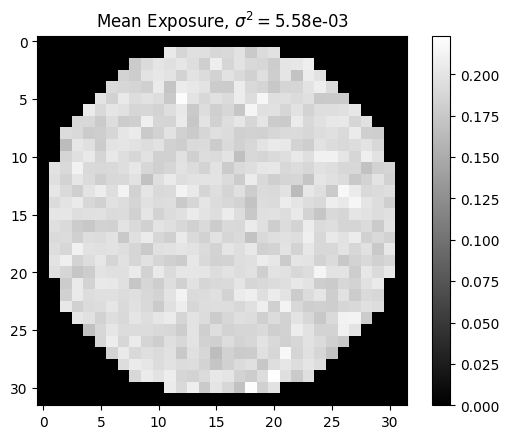

In [163]:
mean_measure = np.mean(np.asarray(noisy_measure), axis=0)

plt.title('Mean Exposure, '+r'$\sigma^{2}=$'+f'{error:.2e}')
plt.imshow(mean_measure, cmap='gray')
plt.colorbar()

In [164]:
# pass to the Log Likelihood function
loglike = normal_logpdf(mean_measure, loc=0, scale=error)

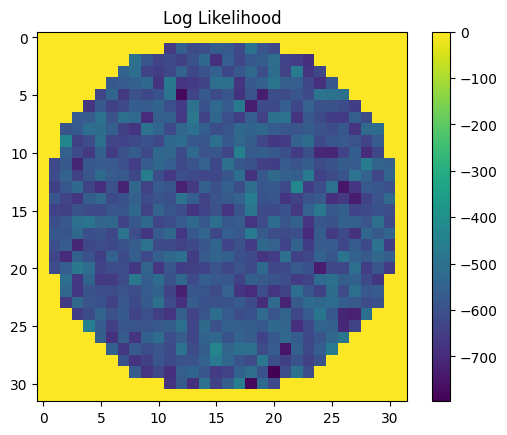

In [165]:
plt.title('Log Likelihood')
plt.imshow(loglike * mask)
plt.colorbar()

In [166]:
FIM = hessian(normal_logpdf)

In [170]:
fisher_matrix = FIM(mean_measure[mask==1], scale=error)

(32, 32)

TypeError: Invalid shape (740, 740, 740) for image data

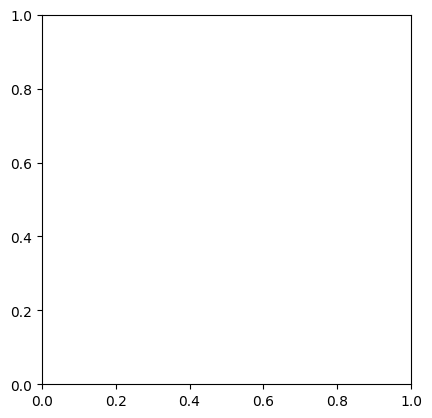

In [171]:
plt.imshow(fisher_matrix, cmap='RdBu_r')
plt.colorbar()
plt.show()

# Set up Log Likelihood Function

In [14]:
# a normal distribution
from jax.scipy.stats.norm import logpdf as normal_logpdf

# a poisson distribution
from jax.scipy.stats.poisson import logpmf as poisson_logpmf